In [1]:
import librosa 
import matplotlib.pyplot as plt
import numpy as np
import pretty_midi
import os

# CQT Configuration 
hop_length_sec = 0.01               # 10 ms
fmin = librosa.note_to_hz('A0')     # Start at A0 (piano)
bins_per_octave = 36                # 3 bins per semitone
n_bins = 267                        # Covers A0 to C8
sr = 22050
hop_length = int(hop_length_sec * sr)

def plot_cqt_with_pianoroll(audio_path, midi_path):
    cqt_list = []
    y, _ = librosa.load(audio_path, sr=sr)

    C = librosa.cqt(
        y, sr=sr,
        hop_length=hop_length,
        fmin=fmin,
        n_bins=n_bins,
        bins_per_octave=bins_per_octave
    )
    C_dB = librosa.amplitude_to_db(np.abs(C), ref=np.max)

    # Load MIDI and get piano roll
    midi_data = pretty_midi.PrettyMIDI(midi_path)
    fs_pianoroll = sr / hop_length  # Frame rate to match CQT
    piano_roll = midi_data.get_piano_roll(fs=fs_pianoroll)

    # Align time axes
    # n_frames = min(C_dB.shape[1], piano_roll.shape[1])
    C_dB = C_dB[:, :1000]
    piano_roll = piano_roll[:, :1000]
    cqt_list.append(C_dB)
    return C_dB, piano_roll



In [2]:
audio_path = 'gen_audio'
midi_path = 'gen_piano'

num_sample =50
cqt_list = []
piano_list = []
for k in range(1):
    for i in range(num_sample):
        if i:
            audio = os.path.join(audio_path, f'gen_random_{i}.mp3')
            midi = os.path.join(midi_path, f'gen_random_{i}.mid')
            # midi = os.path.join(midi_path, 'custom_sequence.mid')
            cqt , piano = plot_cqt_with_pianoroll(audio, midi)
            cqt_list.append(cqt)
            piano_list.append(piano)
cqt_concat = np.concatenate(cqt_list, axis=1)  # along time axis
piano_concat = np.concatenate(piano_list, axis=1)

In [70]:
cqt_concat.shape

(267, 49000)

In [71]:
piano_concat.shape

(128, 49000)

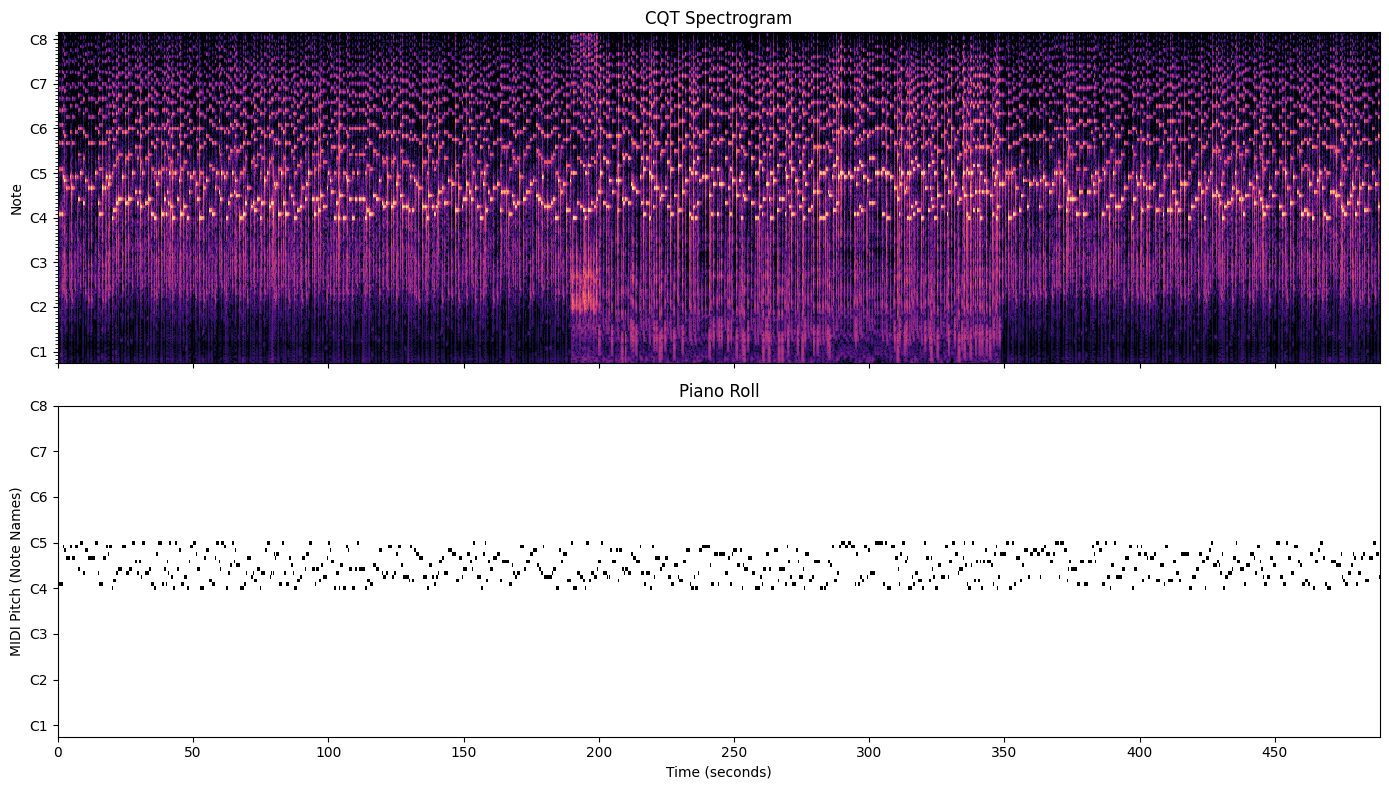

In [72]:
duration_sec = piano_concat.shape[1] * hop_length / sr

# Plot setup
fig, axs = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Plot CQT 
librosa.display.specshow(
    cqt_concat[:,:],
    sr=sr,
    hop_length=hop_length,
    x_axis='s',                  
    y_axis='cqt_note',
    fmin=fmin,
    bins_per_octave=bins_per_octave,
    cmap='magma',
    ax=axs[0]
)
axs[0].set_title("CQT Spectrogram")
axs[0].label_outer()  

# Plot Piano Roll
pitch_min = 21
pitch_max = 108

axs[1].imshow(
    piano_concat[pitch_min:pitch_max+1, :],
    aspect='auto',
    origin='lower',
    cmap='gray_r',
    interpolation='nearest',
    extent=[0, duration_sec, pitch_min, pitch_max]
)

axs[1].set_xlabel('Time (seconds)')
axs[1].set_ylabel('MIDI Pitch (Note Names)')
axs[1].set_title('Piano Roll')
axs[1].set_ylim(pitch_min, pitch_max)

# Label only natural C notes
c_notes = [n for n in range(pitch_min, pitch_max+1)
           if pretty_midi.note_number_to_name(n).startswith('C') and '#' not in pretty_midi.note_number_to_name(n)]
axs[1].set_yticks(c_notes)
axs[1].set_yticklabels([pretty_midi.note_number_to_name(n) for n in c_notes])

plt.tight_layout()
plt.show()


In [ ]:
# import pretty_midi
# import numpy as np

# fs = sr / hop_length  # Sampling rate in Hz (frames per second)

# midi_out = pretty_midi.PrettyMIDI()
# instrument = pretty_midi.Instrument(program=0)  # 0 = Acoustic Grand Piano

# threshold = 0.5  # Choose a velocity threshold (scale: 0-127)

# for pitch in range(piano_concat.shape[0]):
#     # Find where note is active
#     active = piano_concat[pitch] > threshold
#     if not np.any(active):
#         continue

#     # Find note segments (start & end times)
#     idx = np.where(np.diff(np.pad(active.astype(int), (1, 1))) != 0)[0]
#     onsets = idx[::2]
#     offsets = idx[1::2]

#     for start_idx, end_idx in zip(onsets, offsets):
#         start = start_idx / fs
#         end = end_idx / fs
#         velocity = int(np.clip(np.max(piano_concat[pitch, start_idx:end_idx]), 0, 127))

#         note = pretty_midi.Note(velocity=velocity, pitch=pitch + pitch_min, start=start, end=end)
#         instrument.notes.append(note)

# # === Add instrument and write to MIDI file ===
# midi_out.instruments.append(instrument)
# midi_out.write("reconstructed.mid")


In [64]:
def create_sliding_windows(cqt, window_size=9, stride=1):
    pad = window_size // 2
    cqt_padded = np.pad(cqt, ((0, 0), (pad, pad)), mode='edge')
    num_time_bins = cqt.shape[1]

    windows = np.array([
        cqt_padded[:, i:i + window_size]
        for i in range(0, num_time_bins, stride)
    ])
    
    return windows[..., np.newaxis] 

def create_sliding_windows_midi(midi, window_size=9, stride=1):
    pad = window_size // 2
    midi_padded = np.pad(midi, ((0, 0), (pad, pad)), mode='constant', constant_values=0)
    num_time_bins = midi.shape[1]

    windows = np.array([
        midi_padded[:, i:i + window_size]
        for i in range(0, num_time_bins, stride)
    ])
    
    return windows, len(windows)

In [65]:
X_input = create_sliding_windows(cqt_concat, window_size=9, stride=1)  # (num_windows, 267, 9, 1)
print("Sliding Window Output Shape:", X_input.shape)

Y_output, num_windows_midi = create_sliding_windows_midi(piano_concat, window_size=9, stride=1)
print("Sliding Window MIDI Output Shape:", Y_output.shape)

Sliding Window Output Shape: (98000, 267, 9, 1)
Sliding Window MIDI Output Shape: (98000, 128, 9)


In [66]:
Y_output_flattened = np.mean(Y_output, axis=2) > 70  # Shape: (n, 128)

print("Xtrain : ",X_input.shape)
print("out : ",Y_output.shape)
print("Ytrain : ",Y_output_flattened.shape)

Xtrain :  (98000, 267, 9, 1)
out :  (98000, 128, 9)
Ytrain :  (98000, 128)


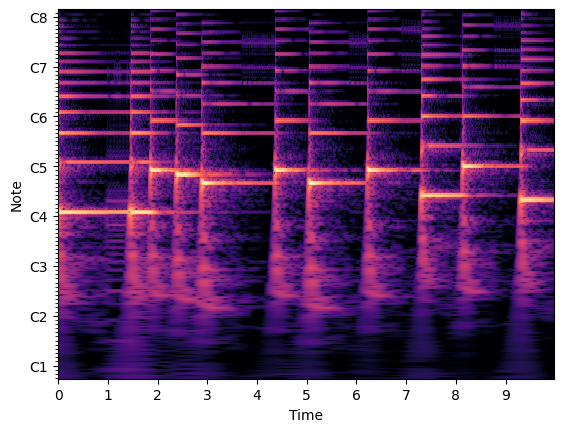

In [52]:
librosa.display.specshow(cqt_concat[:, :1000], sr=sr, hop_length=hop_length,
                            x_axis='time', y_axis='cqt_note',
                            fmin=fmin, bins_per_octave=bins_per_octave,
                            cmap='magma')


In [ ]:
import tensorflow as tf
num_classes = 128
import datetime


log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# Create the callback
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(10, (16, 2), activation='relu', padding='valid', input_shape=(267, 9, 1), name="conv1"),
    tf.keras.layers.MaxPooling2D((2, 2), name="pool1"),
    tf.keras.layers.Conv2D(20, (11, 3), activation='relu', padding='valid', name="conv2"),
    tf.keras.layers.MaxPooling2D((2, 2), name="pool2"),
    tf.keras.layers.Flatten(name="flatten"),
    tf.keras.layers.Dense(256, activation='relu', name="fc1"),
    tf.keras.layers.Dropout(0.5, name="dropout"),
    tf.keras.layers.Dense(num_classes, activation='sigmoid', name="fc2")
])

model.summary()

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

c:\Users\napat\Documents\GitHub\env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1 (Conv2D)                  │ (None, 252, 8, 10)     │           330 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool1 (MaxPooling2D)            │ (None, 126, 4, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2 (Conv2D)                  │ (None, 116, 2, 20)     │         6,620 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool2 (MaxPooling2D)            │ (None, 58, 1, 20)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1160)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 256)            │       297,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 128)            │        32,896 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 337,062 (1.29 MB)

 Trainable params: 337,062 (1.29 MB)

 Non-trainable params: 0 (0.00 B)

In [68]:
model.fit(X_input, Y_output_flattened, 
          epochs=50, 
          batch_size=256,
          validation_split=0.2,
          callbacks=[tensorboard_callback]
          )
model.save("adjust_pool.h5")

Epoch 1/50
307/307 ━━━━━━━━━━━━━━━━━━━━ 16s 51ms/step - accuracy: 0.9578 - loss: 7.0172e-05 - val_accuracy: 0.9573 - val_loss: 5.0588e-05
Epoch 2/50
307/307 ━━━━━━━━━━━━━━━━━━━━ 15s 49ms/step - accuracy: 0.9571 - loss: 5.6999e-05 - val_accuracy: 0.9573 - val_loss: 5.0965e-05
Epoch 3/50
307/307 ━━━━━━━━━━━━━━━━━━━━ 17s 54ms/step - accuracy: 0.9568 - loss: 6.1294e-05 - val_accuracy: 0.9573 - val_loss: 4.7699e-05
Epoch 4/50
307/307 ━━━━━━━━━━━━━━━━━━━━ 17s 54ms/step - accuracy: 0.9579 - loss: 1.3239e-04 - val_accuracy: 0.9573 - val_loss: 8.5638e-05
Epoch 5/50
307/307 ━━━━━━━━━━━━━━━━━━━━ 16s 53ms/step - accuracy: 0.9580 - loss: 1.0153e-04 - val_accuracy: 0.9573 - val_loss: 7.8245e-05
Epoch 6/50
307/307 ━━━━━━━━━━━━━━━━━━━━ 17s 54ms/step - accuracy: 0.9571 - loss: 7.8968e-05 - val_accuracy: 0.9573 - val_loss: 5.6191e-05
Epoch 7/50
307/307 ━━━━━━━━━━━━━━━━━━━━ 17s 54ms/step - accuracy: 0.9563 - loss: 6.2662e-05 - val_accuracy: 0.9573 - val_loss: 4.6063e-05
Epoch 8/50
307/307 ━━━━━━━━━━━━━━━

In [261]:
!tensorboard --logdir=logs/fit

^C
